<a href="https://colab.research.google.com/github/Azalea2406/DeepFake-Detection/blob/main/Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os

Set image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [8]:
import os

root_path = "/content/deepfake_dataset"

for root, dirs, files in os.walk(root_path):
    level = root.replace(root_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files[:5]:  # Show a few files per directory
        print(f"{subindent}{f}")


## Load kaggle.json from Google Drive

In [11]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
# Step 2: Copy kaggle.json from your Drive to the correct location
# Make sure to update the path below based on where you put kaggle.json in your Drive
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/'SIP Project'/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [13]:
# Step 3: Install kaggle CLI
!pip install -q kaggle

import kagglehub

 '#Download latest version'
path = kagglehub.dataset_download("manjilkarki/deepfake-and-real-images")

print("Path to dataset files:", path)

In [14]:
# Step 4: Download the dataset (replace this with your dataset path)
!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 98% 1.66G/1.68G [00:11<00:00, 231MB/s]
100% 1.68G/1.68G [00:11<00:00, 155MB/s]


In [15]:
# Step 5: Unzip it
!unzip -q '*.zip'

In [16]:
#Step 6 List all files/folders in the current directory
!ls


Dataset  deepfake-and-real-images.zip  drive  sample_data


In [17]:
#Step 7
# Unzip by exact filename if wildcard failed
!unzip -q deepfake-and-real-images.zip -d deepfake_dataset

# Check what got extracted
!ls -R deepfake_dataset

Streaming output truncated to the last 5000 lines.
fake_12600.jpg	fake_16137.jpg	fake_1997.jpg	fake_5532.jpg  fake_9069.jpg
fake_12601.jpg	fake_16138.jpg	fake_1998.jpg	fake_5533.jpg  fake_906.jpg
fake_12602.jpg	fake_16139.jpg	fake_1999.jpg	fake_5534.jpg  fake_9070.jpg
fake_12603.jpg	fake_1613.jpg	fake_199.jpg	fake_5535.jpg  fake_9071.jpg
fake_12604.jpg	fake_16140.jpg	fake_19.jpg	fake_5536.jpg  fake_9072.jpg
fake_12605.jpg	fake_16141.jpg	fake_1.jpg	fake_5537.jpg  fake_9073.jpg
fake_12606.jpg	fake_16142.jpg	fake_2000.jpg	fake_5538.jpg  fake_9074.jpg
fake_12607.jpg	fake_16143.jpg	fake_2001.jpg	fake_5539.jpg  fake_9075.jpg
fake_12608.jpg	fake_16144.jpg	fake_2002.jpg	fake_553.jpg   fake_9076.jpg
fake_12609.jpg	fake_16145.jpg	fake_2003.jpg	fake_5540.jpg  fake_9077.jpg
fake_1260.jpg	fake_16146.jpg	fake_2004.jpg	fake_5541.jpg  fake_9078.jpg
fake_12610.jpg	fake_16147.jpg	fake_2005.jpg	fake_5542.jpg  fake_9079.jpg
fake_12611.jpg	fake_16148.jpg	fake_2006.jpg	fake_5543.jpg  fake_907.jpg
fake_12612

In [19]:
# The data was unzipped into deepfake_dataset, not Dataset.
# Update the path to reflect the actual unzipped directory.
dataset_path = '/content/deepfake_dataset/Dataset' # The actual dataset folder is inside deepfake_dataset


# Confirm structure by checking the actual path
for phase in ['Train', 'Validation', 'Test']:
    print(f"\n{phase} ->")
    for cls in ['Real', 'Fake']:
        # Construct the path using the correct base directory
        folder_path = os.path.join(dataset_path, phase, cls)
        try:
            # Check if the folder exists before trying to list its contents
            if os.path.exists(folder_path):
                 print(f"{cls}: {len(os.listdir(folder_path))} images")
            else:
                 print(f"{cls}: Folder not found at {folder_path}")
        except Exception as e:
            print(f"Error listing files for {folder_path}: {e}")


Train ->
Real: 70001 images
Fake: 70001 images

Validation ->
Real: 19787 images
Fake: 19641 images

Test ->
Real: 5413 images
Fake: 5492 images


### STEP 2: Load Datasets from Disk

In [20]:


train_ds = image_dataset_from_directory(
    os.path.join(dataset_path, 'Train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = image_dataset_from_directory(
    os.path.join(dataset_path, 'Validation'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = image_dataset_from_directory(
    os.path.join(dataset_path, 'Test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


### STEP 3: Prefetch to speed up

In [21]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### STEP 4: Define the ResNet50-based Model

In [22]:
base_model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze base layers

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

### STEP 5: Train the Model

In [23]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # You can increase this
)

Epoch 1/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 473s 105ms/step - accuracy: 0.6586 - loss: 0.6484 - val_accuracy: 0.7879 - val_loss: 0.4488
Epoch 2/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 534s 114ms/step - accuracy: 0.7714 - loss: 0.4711 - val_accuracy: 0.8009 - val_loss: 0.4312
Epoch 3/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 453s 104ms/step - accuracy: 0.7825 - loss: 0.4518 - val_accuracy: 0.8071 - val_loss: 0.4214
Epoch 4/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 547s 114ms/step - accuracy: 0.7874 - loss: 0.4471 - val_accuracy: 0.8089 - val_loss: 0.4200
Epoch 5/5
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 455s 104ms/step - accuracy: 0.7855 - loss: 0.4474 - val_accuracy: 0.8100 - val_loss: 0.4178


### STEP 6: Evaluate on Test Data

In [24]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")

341/341 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.7284 - loss: 0.5606

✅ Test Accuracy: 72.90%


### STEP 7 (Optional): Plot Accuracy/Loss Curves

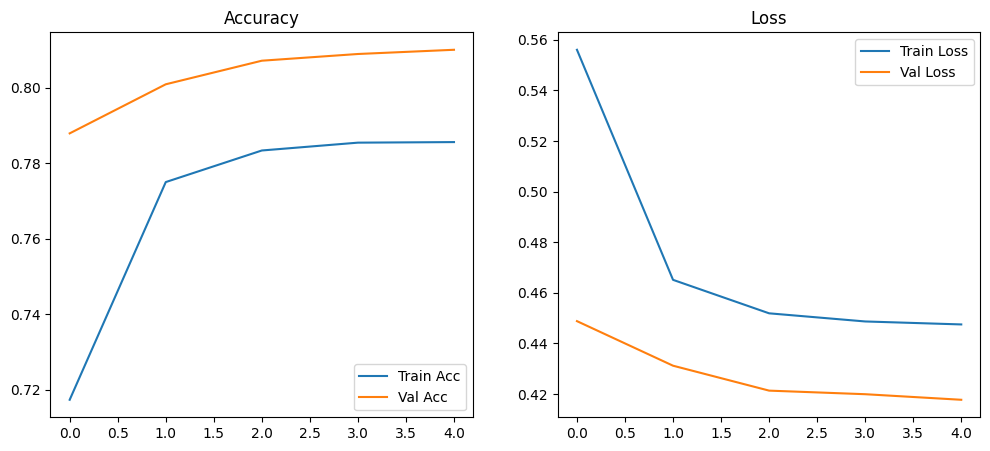

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.show()

### STEP 8 (Optional): Predict Single Image

In [27]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) / 255.0  # Normalize

    prediction = model.predict(img_array)[0][0]
    label = 'Fake' if prediction > 0.5 else 'Real'
    print(f"Prediction: {label} ({prediction:.4f})")

# Example usage
# predict_image('/content/deepfake_dataset/Dataset/Test/Fake/example.jpg')

###  Training vs Validation Accuracy and Loss Curves

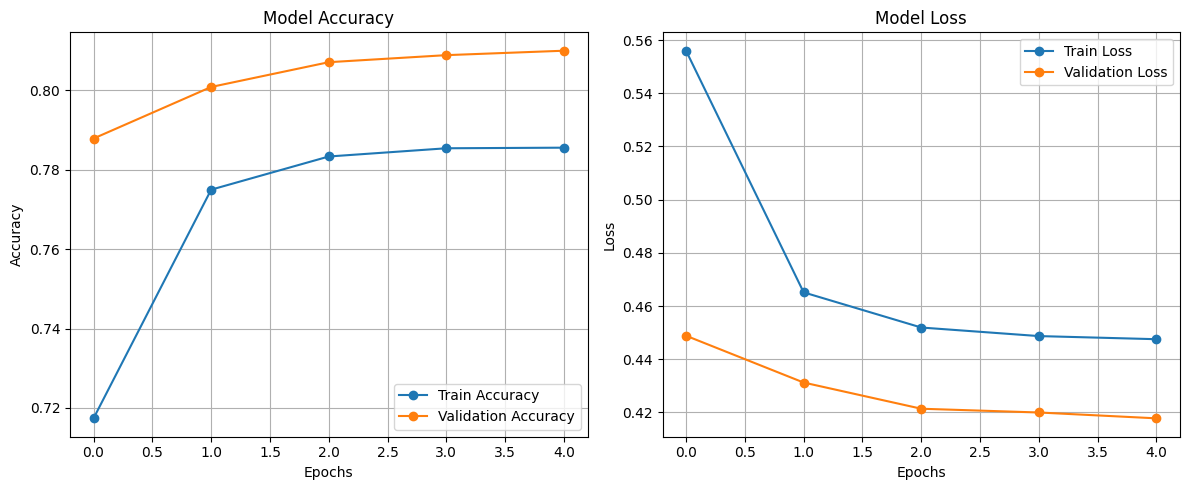

In [28]:
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Call this after training
plot_training_curves(history)


In [ ]:
### Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

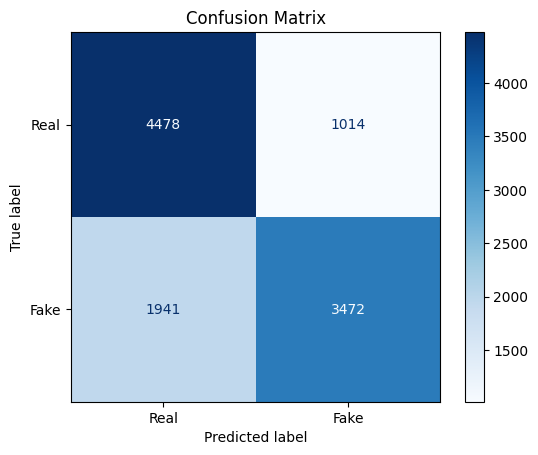

In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions on the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


### ROC Curve & AUC Score

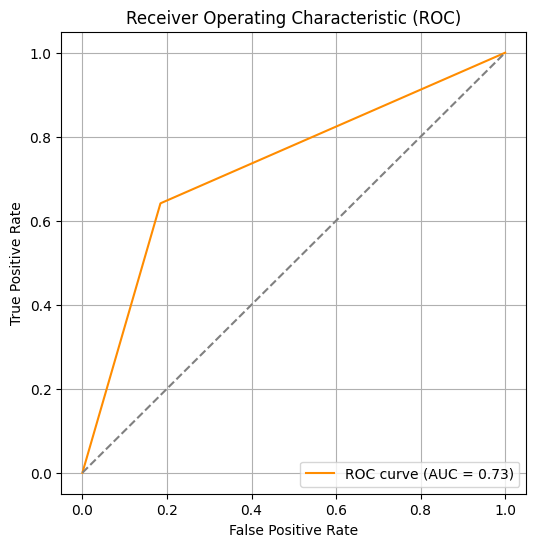

In [30]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
